In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=100000) # just read first 10000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    # cluster jets from the particles in one observation
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)): # for each jet get (px, py, pz, e)
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [7]:
loaded_data = data
# data = loaded_data

In [8]:
data = np.array(data)
data.shape

(1477373, 4)

In [11]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [12]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [13]:
# get the inverse iqr proportion for each feature used to scale their weights in the loss function
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.03073949 0.0307984  0.38423165 1.        ]


# VAE Model

In [14]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [15]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [17]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [18]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [19]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [20]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [21]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
batch_size = 1000
epochs = 200

In [24]:
x_train.shape

(1181898, 4)

In [25]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [26]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 1181898 samples, validate on 147737 samples
Epoch 1/200
1181898/1181898 [==============================] - 6s 5us/step - loss: 0.0455 - val_loss: 0.0158
Epoch 2/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 4/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0155 - val_loss: 0.0155
Epoch 5/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 6/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 7/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 8/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 9/200
1181898/1181898 [==============================] - 5s 4us/step 

1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0048 - val_loss: 0.0048
Epoch 76/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0048 - val_loss: 0.0049
Epoch 77/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 78/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0054 - val_loss: 0.0055
Epoch 79/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0054 - val_loss: 0.0056
Epoch 80/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0053 - val_loss: 0.0052
Epoch 81/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0049 - val_loss: 0.0048
Epoch 82/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0048 - val_loss: 0.0046
Epoch 83/200
1181898/1181898 [==============================] - 5s 4us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 84/200
1181898/11

# Visualization

In [27]:
import matplotlib.pyplot as plt

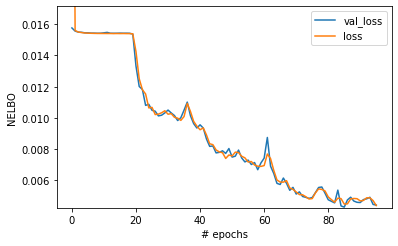

In [28]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [29]:
predictions = vae.predict(x_test)

In [66]:
# mse on test set
p = vae.predict(x_train)
print(mse(p, x_train))

tf.Tensor(0.08666188, shape=(), dtype=float32)


In [31]:
distr = (x_test - predictions) / x_test

In [32]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [33]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [34]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

(array([   568.,    534.,    518.,    525.,    469.,    590.,    586.,
           590.,    630.,    676.,    648.,    743.,  67992.,  21794.,
         10046.,   6824.,   5034.,   4363.,   4293.,   4278.,   4534.,
          6116.,  13260.,  97845., 203656.,  15557.,   9027.,   5505.,
          3956.,   2706.,   2337.,   2190.,   1582.,   1740.,   1573.,
          1249.,   1193.,   1040.,   1157.,   1220.,    897.,    863.,
           912.,    821.,    745.,    686.,    707.,    664.,    648.]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
         0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
         0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.

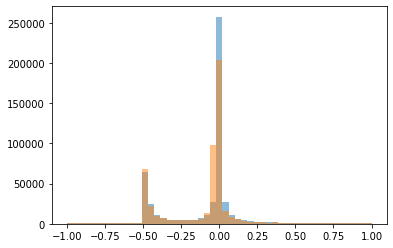

In [35]:
# overall pred vs input
bins = np.linspace(-1, 1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)

(array([  1727.,   1814.,   1977.,   2098.,   2254.,   2654.,   3199.,
          3809.,   4231.,   4957.,   5957.,   7528.,  14519.,  25505.,
        183924.,  31350.,  16932.,  14287.,  11718.,  10372.,  10252.,
         10179.,  10776.,   9013.,   7307.,   6143.,   4739.,   4176.,
          3708.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

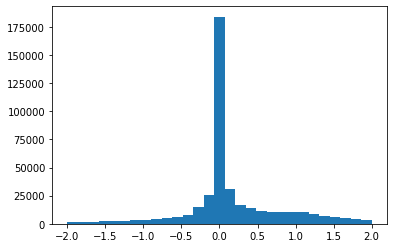

In [36]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)

## Stacking output (orange) over input (blue) for px, py, pz, E

(array([  129.,   107.,   123.,   118.,   132.,   107.,   127.,   148.,
          156.,   157.,   151.,   316.,   870.,  2274.,  2829.,  3767.,
        28034., 41556., 12860., 14588.,  9762.,  1285.,   670.,   582.,
          588.,   601.,   459.,   376.,   283.,   224.,   260.,   222.,
          171.,   162.,   155.,   123.,   122.,   126.,   107.]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.11794872,  0.12820513,  0.13846154,  0.14871795,
         0.15897436,  0.16923077,  0.17948718,  0.18974359,  0.2       ]),
 <a list of 39 Patch objects>)

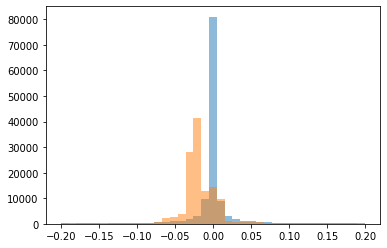

In [37]:
# px
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)

In [38]:
print(mse(px,px_pred))

tf.Tensor(0.14545695, shape=(), dtype=float32)


(array([   94.,   113.,   110.,   111.,   126.,   157.,   243.,   394.,
          304.,   298.,   341.,   429.,   924.,  1572.,  2154.,  4174.,
         8363.,  5594.,  8020., 78603.,  5420.,   372.,   372.,   396.,
          380.,   393.,   799.,   519.,   411.,   338.,   299.,   308.,
          193.,   145.,   134.,   122.,   129.,    87.,   115.]),
 array([-0.2       , -0.18974359, -0.17948718, -0.16923077, -0.15897436,
        -0.14871795, -0.13846154, -0.12820513, -0.11794872, -0.10769231,
        -0.0974359 , -0.08717949, -0.07692308, -0.06666667, -0.05641026,
        -0.04615385, -0.03589744, -0.02564103, -0.01538462, -0.00512821,
         0.00512821,  0.01538462,  0.02564103,  0.03589744,  0.04615385,
         0.05641026,  0.06666667,  0.07692308,  0.08717949,  0.0974359 ,
         0.10769231,  0.11794872,  0.12820513,  0.13846154,  0.14871795,
         0.15897436,  0.16923077,  0.17948718,  0.18974359,  0.2       ]),
 <a list of 39 Patch objects>)

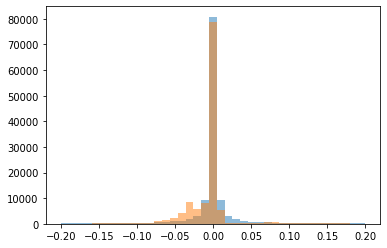

In [39]:
# py
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

In [40]:
print(mse(py,py_pred))

tf.Tensor(0.18967232, shape=(), dtype=float32)


(array([  372.,   380.,   427.,   482.,   512.,   511.,   548.,   621.,
          718.,   834.,   889.,  1072.,  1349.,  1534.,  1747.,  3181.,
         4793.,  8309., 16084., 44045.,  9854.,  4966.,  3268.,  2387.,
         1802.,  1499.,  1388.,   790.,   721.,   843.,   899.,   462.,
          499.,   624.,   504.,   529.,   389.,   402.,   386.]),
 array([-0.5       , -0.47435897, -0.44871795, -0.42307692, -0.3974359 ,
        -0.37179487, -0.34615385, -0.32051282, -0.29487179, -0.26923077,
        -0.24358974, -0.21794872, -0.19230769, -0.16666667, -0.14102564,
        -0.11538462, -0.08974359, -0.06410256, -0.03846154, -0.01282051,
         0.01282051,  0.03846154,  0.06410256,  0.08974359,  0.11538462,
         0.14102564,  0.16666667,  0.19230769,  0.21794872,  0.24358974,
         0.26923077,  0.29487179,  0.32051282,  0.34615385,  0.37179487,
         0.3974359 ,  0.42307692,  0.44871795,  0.47435897,  0.5       ]),
 <a list of 39 Patch objects>)

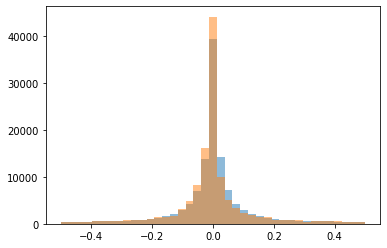

In [41]:
# pz
bins = np.linspace(-0.5, 0.5, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

In [42]:
print(mse(pz,pz_pred))

tf.Tensor(0.0073313154, shape=(), dtype=float32)


(array([    0.,     0.,     0.,     0., 46347., 27124., 11362.,  7046.,
         4618.,  3600.,  2975.,  2292.,  1999.,  1608.,  1531.,  1220.,
         1073.,   892.,   723.,   633.,   578.,   579.,   488.,   503.,
          504.,   423.,   400.,   374.,   234.,   226.,   334.,   320.,
          321.,   350.,   323.,   293.,   295.,   243.,   221.]),
 array([-0.6       , -0.57692308, -0.55384615, -0.53076923, -0.50769231,
        -0.48461538, -0.46153846, -0.43846154, -0.41538462, -0.39230769,
        -0.36923077, -0.34615385, -0.32307692, -0.3       , -0.27692308,
        -0.25384615, -0.23076923, -0.20769231, -0.18461538, -0.16153846,
        -0.13846154, -0.11538462, -0.09230769, -0.06923077, -0.04615385,
        -0.02307692,  0.        ,  0.02307692,  0.04615385,  0.06923077,
         0.09230769,  0.11538462,  0.13846154,  0.16153846,  0.18461538,
         0.20769231,  0.23076923,  0.25384615,  0.27692308,  0.3       ]),
 <a list of 39 Patch objects>)

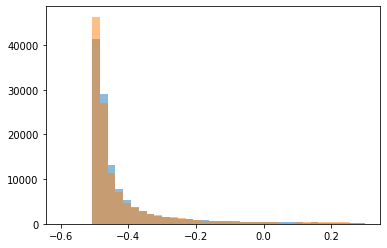

In [43]:
# E
bins = np.linspace(-0.6,0.3, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [44]:
print(mse(e,e_pred))

tf.Tensor(0.0044255396, shape=(), dtype=float32)


In [45]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [46]:
bins = np.linspace(-2, 2, 30)

(array([ 530.,  518.,  599.,  597.,  632.,  651.,  660.,  775.,  840.,
         953., 1110., 1247., 1778., 2679., 4631., 5548., 3616., 3380.,
        2998., 2873., 3414., 3599., 3527., 2544., 1908., 1588., 1324.,
        1192., 1063.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

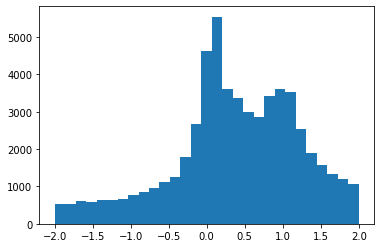

In [47]:
plt.hist(d_px, bins=bins)

(array([ 816.,  889.,  920.,  981., 1024., 1101., 1199., 1402., 1491.,
        1716., 1980., 2222., 2683., 3377., 4480., 5856., 5037., 4605.,
        4363., 4330., 4568., 4881., 4544., 4091., 3319., 2765., 2429.,
        2178., 1912.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

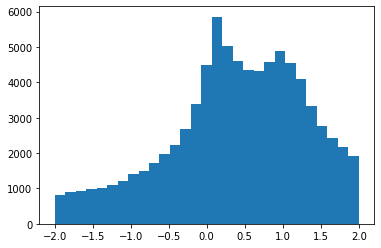

In [48]:
plt.hist(d_py, bins=bins)

(array([  368.,   397.,   431.,   499.,   572.,   866.,  1296.,  1578.,
         1825.,  2162.,  2628.,  3621.,  9039., 13905., 40507., 15771.,
         7579.,  6084.,  4252.,  3097.,  2214.,  1666.,  2685.,  2358.,
         2060.,  1779.,   978.,   795.,   725.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

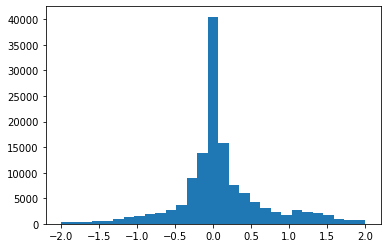

In [49]:
plt.hist(d_pz, bins=bins)

(array([1.30000e+01, 1.00000e+01, 2.70000e+01, 2.10000e+01, 2.60000e+01,
        3.60000e+01, 4.40000e+01, 5.40000e+01, 7.50000e+01, 1.26000e+02,
        2.39000e+02, 4.38000e+02, 1.01900e+03, 5.54400e+03, 1.34306e+05,
        4.17500e+03, 7.00000e+02, 2.18000e+02, 1.05000e+02, 7.20000e+01,
        5.60000e+01, 3.30000e+01, 2.00000e+01, 2.00000e+01, 2.00000e+01,
        1.10000e+01, 8.00000e+00, 1.10000e+01, 8.00000e+00]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

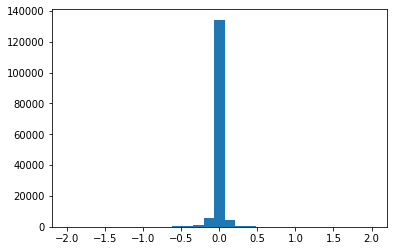

In [50]:
plt.hist(d_e, bins=bins)

# Anomaly Detection

In [51]:
from sklearn.metrics import mean_squared_error

In [72]:
all_data = np.concatenate((x_train, x_val, x_test))
all_pred = vae.predict(all_data)

In [75]:
# get the mse of all predictions
errors = (np.square(all_data - all_pred)).mean(axis=1)
mse_thresh = np.quantile(errors,0.95)

In [102]:
# all the inputs that had high mse
data_df = pd.DataFrame(data)
data_df["mse"] = errors
data_df["outlier"] = 0

In [103]:
data_df.loc[data_df["mse"] > mse_thresh, "outlier"] = 1

In [104]:
data_df.loc[data_df["outlier"] == 1]

,0,1,2,3,mse,outlier
35,-1317.691456,389.936193,-1302.594766,1905.577540,1.038930,1
36,1225.550883,-382.376007,-1222.392092,1793.310317,1.230168,1
49,878.307028,1182.994300,1984.545138,2597.609007,0.782682,1
80,140.122818,1264.068574,1801.851240,2218.464338,0.518260,1
82,27.228548,-424.471893,848.325220,950.819532,0.530928,1
...,...,...,...,...,...,...
1477207,1228.977610,-98.320090,-1476.941705,1947.488851,1.016722,1
1477241,849.959136,1231.328523,-428.464252,1580.165863,0.964958,1
1477299,-1035.056312,797.041979,-207.496224,1327.057082,0.840354,1
1477316,-1183.348263,266.011832,2203.505011,2527.528651,1.261836,1
